In [17]:
import os 
from glob import glob
import pandas as pd 
import numpy as np 
from scipy.signal import find_peaks_cwt
import matplotlib.pyplot as plt 

%matplotlib inline

In [2]:
input_date = "20190320"

input_path = os.path.join("data", "raw", input_date)
output_path = os.path.join("data", "processed", input_date)
if not os.path.isdir(output_path):
    os.mkdir(output_path)
if not os.path.isdir(os.path.join(output_path, "live")):
    os.mkdir(os.path.join(output_path, "live"))

bg_path = os.path.join(input_path, "background.csv")
calib_wl_path = os.path.join(input_path, "calib_wl.csv")
live_path = os.path.join(input_path, "live")
wl = [i for i in range(650, 1001, 10)]

bg = np.loadtxt(bg_path, delimiter=",")
calib_wl = np.loadtxt(calib_wl_path, delimiter=',')


live_list = glob(os.path.join(live_path, "live_*_*.csv"))
live_list.sort(key=lambda x: (x.split('_')[1], x.split('_')[2].strip(".csv")))
live_idx = [i.split("/")[-1].strip("live_").strip(".csv") for i in live_list]

In [25]:
l, n = live_list[0], live_idx[0]

live = np.loadtxt(l, delimiter=",")

live -= bg.mean(0)

live_interp = []
for l in live:
    live_interp.append(np.interp(wl, calib_wl, l))
live_interp = np.asarray(live_interp)

live_crop = live[:, (calib_wl > 600) & (calib_wl < 950)]
live_crop = live_crop.mean(1)
live_crop = 1 - live_crop/65535

# remove artifact


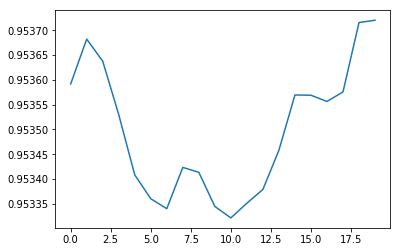

In [29]:
plt.plot(live_crop[120:140])

In [10]:
from PyEMD import EMD
imf = EMD().emd(live_crop, np.arange(len(live_crop)))

In [13]:
imf.shape

(6, 691)

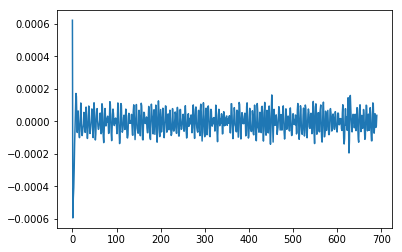

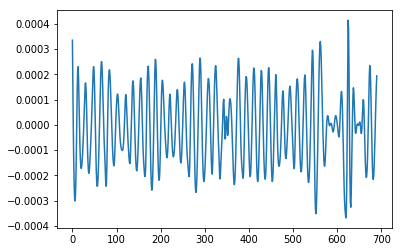

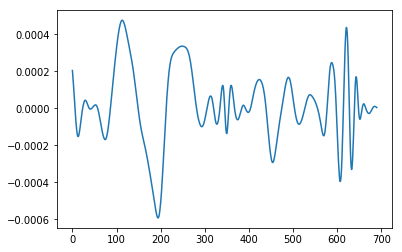

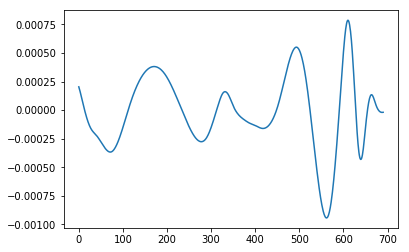

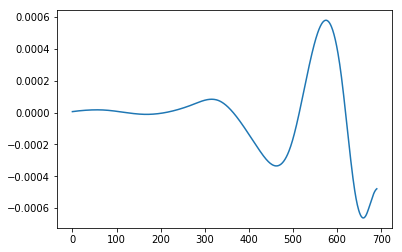

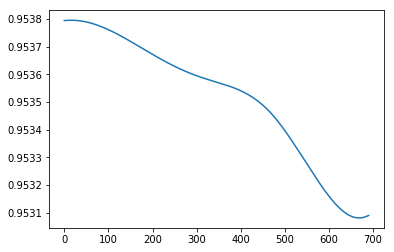

In [27]:
for i in imf:
    plt.plot(i)
    plt.show()

0.0004938987256796035


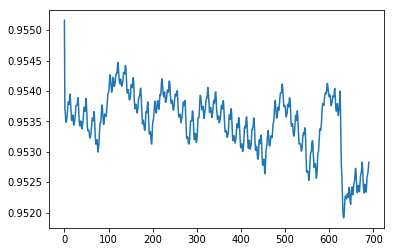

0.00040874388081462283


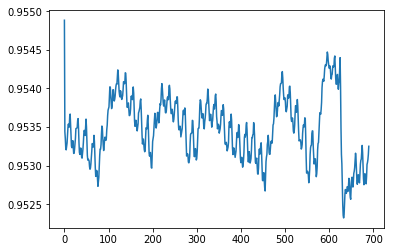

0.00038495080949777427


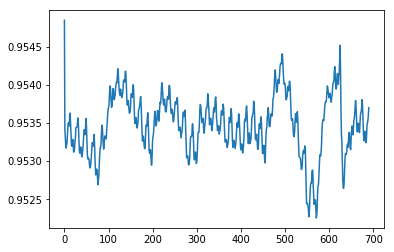

0.0002561567869258956


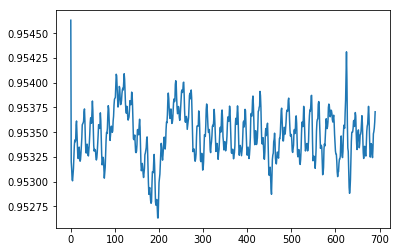

0.00016796830690952186


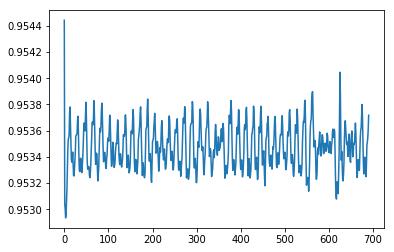

In [26]:
# for i in imf:
#     plt.plot(i)
#     plt.show()
# plt.plot(imf.sum(0))
# plt.show()
# plt.plot(live_crop - imf[-1] + imf[-1].mean())
# plt.show()
lc = live_crop
print(np.std(lc))
plt.plot(lc)
plt.show()
for i in range(1, 5):
    if i == imf.shape[0]:
        break
    lc -= imf[-i] - imf[-i].mean()
    plt.plot(lc, label="%f" % np.std(lc))
    plt.legend()
    plt.show()

In [ ]:
max_index = find_peaks_cwt(live_crop, np.arange(1, 20))
min_index = find_peaks_cwt(1-live_crop, np.arange(1, 20))

plt.figure()
plt.plot(live_crop)
plt.scatter(max_index, live_crop[max_index], label='max')
plt.scatter(min_index, live_crop[min_index], label='min')
plt.legend()
plt.grid()
plt.xlabel("time[frame]")
plt.ylabel("reflectance[-]")
plt.savefig(os.path.join(output_path, "live", input_date + "_" + n + "_peak.png"))
plt.clf()

live_max = live[max_index].mean(0)
live_min = live[min_index].mean(0)

live_max_interp = np.interp(wl, calib_wl, live_max)
live_min_interp = np.interp(wl, calib_wl, live_min)


plt.figure()
plt.plot(wl, live_max_interp, label="max")
plt.plot(wl, live_min_interp, label="min")
plt.legend()
plt.grid()
plt.xlabel("wavelength[nm]")
plt.ylabel("reflectance[-]")
plt.savefig(os.path.join(output_path, "live", input_date + "_" + n + ".png"))
plt.clf()

df_dict = {}
df_dict["wavelength"] = wl
df_dict["max"] = live_max_interp 
df_dict["min"] = live_min_interp

df = pd.DataFrame(df_dict)

df.to_csv(os.path.join(output_path, "live", input_date + "_" + n + ".csv"))